In [2]:
using Plots
using Random
using Statistics
using LinearAlgebra
using BenchmarkTools
using Plots

In [17]:
# equations and structures

function initialize_simulation_hyperparameters(Lx::Float64,Ly::Float64,dt::Float64,dx::Float64,dy::Float64,Nx::Int64,Ny::Int64, neutrient_field::Matrix{Float64})
    return Dict("Lx"=>Lx, "Ly"=>Ly, "dt"=>dt, "dx"=>dx, "dy"=>dy, "Nx"=>Nx, "Ny"=>Ny, "neutrient_field"=>neutrient_field)
end

function initialize_simulation_hyperparameters(Lx::Float64,Ly::Float64,dt::Float64,dx::Float64,dy::Float64,Nx::Int64,Ny::Int64)
    return Dict("Lx"=>Lx, "Ly"=>Ly, "dt"=>dt, "dx"=>dx, "dy"=>dy, "Nx"=>Nx, "Ny"=>Ny)
end

#intended to be inside dict of cell types
function initialize_type_hyperparameters(tau_u::Float64, D::Float64, eta_s::Float64, eta::Float64, gamma::Float64, alpha::Float64, beta::Float64, beta_s::Float64, V_max::Float64, L::Float64)
    return Dict("tau_u" => tau_u, "D" => D, "eta_s" => eta_s, "eta" => eta, "gamma" => gamma, "alpha" => alpha, "beta" => beta, "beta_s" => beta_s, "V_max" => V_max, "L" => L)
end

function extract_hyperparameter_vars(cell_hyp)
    for (key, value) in cell_hyp
        eval(Meta.parse("$key = $value"))
    end
    return tau_u, D, eta_s, eta, gamma, alpha, beta, beta_s, V_max, L
end

mutable struct PhaseField
    field::Matrix{Float64}
    field_laplacian::Matrix{Float64}
    square_term::Matrix{Float64}
    h_field::Matrix{Float64}
    volume::Float64
    type::String
    type_hyp::Dict
end

function PhaseField(hpars::Dict, type::String, type_hyp::Dict, field::Matrix{Float64})
    #=
    types_hpars is dict of cell hyperparameter dicts
    type is type name
    hpars are simulation hyperparameters
    field is a field matrix
    =#
    Nx, Ny = hpars["Nx"], hpars["Ny"]
    field_laplacian = laplacian(hpars, field)
    square_term = field .* (1 .- field)
    h_field = h.(field)
    return PhaseField(field, field_laplacian, square_term, h_field, 0., type, type_hyp)
end

function PhaseField(hpars::Dict, type::String, type_hyp::Dict)
    #=
    types_hpars is dict of cell hyperparameter dicts
    type is type name
    hpars are simulation hyperparameters
    field is assumed to be zero everywhere
    =#
    Nx, Ny = hpars["Nx"], hpars["Ny"]
    field = zeros(Nx, Ny)
    field_laplacian = zeros(Nx, Ny)
    square_term = zeros(Nx, Ny)
    h_field = zeros(Nx, Ny)
    return PhaseField(field, field_laplacian, square_term, h_field, 0., type, type_hyp)
end

h(f) = f * f * (3 - 2 *f)
kdelta(i,j) = i == j ? 1 : 0
volume(f::Matrix{Float64}, dx::Float64, dy::Float64) = sum(f)*dx*dy

function laplacian(hpars::Dict, f::Matrix{Float64})
    # rows, cols = hpars["Nx"], hpars["Ny"]
    dx, dy = hpars["dx"], hpars["dy"]
    # Rolling operations
    f_ip1 = circshift(f, (-1, 0))  # f(i+1, j)
    f_im1 = circshift(f, (1, 0))   # f(i-1, j)
    f_jp1 = circshift(f, (0, -1))  # f(i, j+1)
    f_jm1 = circshift(f, (0, 1))   # f(i, j-1)
    # Discrete Laplacian computation
    L = (f_ip1 + f_im1 - 2 * f) / dx^2
    L += (f_jp1 + f_jm1 - 2 * f) / dy^2
    return L
end

function calculate_phi(hpars::Dict, fields::Vector{PhaseField}, type::String)
    #=
    calculates phi value for single cell type (summs fields)
    =#
    phi = zeros(size(fields[1].field))
    for field in fields
        if (field.type == type)
            phi .+= field.field
        end
    end
    return phi
end

function sum_h_fields(fields::Vector{PhaseField}, type::String)
    #=
    summs h(PhaseField.field)
    =#
    sum_h = zeros(size(fields[1]))
    for field in fields
        if (field.type == type)
            phi .+= field.h_field
        end
    end
    return sum_h
end

function meshgrid(x::LinRange, y::LinRange)
    return repeat(x', length(y), 1), repeat(y, 1, length(x))
end

# check if working!
function generate_cell!(field::PhaseField, xcenter::Int64, ycenter::Int64, radius::Float64 = 0.5, smooothness::Float64 = 1)
    x = LinRange(0, Lx, Nx)
    y = LinRange(0, Ly, Ny)
    xv, yv = meshgrid(x, y)
    field.field .+= -tanh.(smoothness .* (sqrt.((xv .- xcenter).^2 .+ (yv .- ycenter).^2) .- radius)) / 2 .+ 0.5
end

function take_position(hpars::Dict, field::PhaseField)
    Lx, Ly, Nx, Ny = hpars["Lx"], hpars["Ly"], hpars["Nx"], hpars["Ny"]

    x = LinRange(0, Lx, Nx)
    y = LinRange(0, Ly, Ny)

    X, Y = meshgrid(x, y)

    total_mass = sum(field.field)
    com_x = sum(X .* field.field) / total_mass
    com_y = sum(Y .* field.field) / total_mass

    return com_x, com_y
end

function cell_divide!(hpars::Dict, field::PhaseField, volLim::Float64, smoothness::Float64)
    vol = field.volume
    if volLim > field.type_hyp["V_max"]
        error("volume limit for cell division should be smaller than absolute volume limit for given specie")
    elseif vol < volLim
        return false
    else
        Nx, Ny = hpars["Nx"], hpars["Ny"]
        new_radius = sqrt(vol / pi * 0.5)
        theta = rand() * 2 * pi
        omega_x, omega_y = cos(theta), sin(theta)
        com_x, com_y = take_position(hpars, field)
        
        field2 = zeros(Nx, Ny)
        x = LinRange(0, Lx, Nx)
        y = LinRange(0, Ly, Ny)
        xv, yv = meshgrid(x, y)
        new_u_1 = (tanh.(smoothness .* (omega_x .* (xv .- com_x) + omega_y .* (yv .- com_y))) .+ 1).*field.field .* 0.5
        new_u_2 = (-tanh.(smoothness .* (omega_x .* (xv .- com_x) + omega_y .* (yv .- com_y))) .+ 1).*field.field .* 0.5

        field.field = new_u_1
        return new_u_2
    end
end

function update_phase_field!(hpars::Dict, u::PhaseField)
    lap = laplacian(hpars, u.field)
    h_f = h.(u.field)
    u.field_laplacian = lap
    u.h_field = h_f
    u.volume = volume(h_f, hpars["dx"], hpars["dy"])
    u.square_term = u.field .* (1 .- u.field)
end

update_phase_field! (generic function with 1 method)

In [4]:
# defining ODE v1

function initialize_simulation_hyperparameters(Lx::Float64,Ly::Float64,dt::Float64,dx::Float64,dy::Float64,Nx::Int64,Ny::Int64)
    return Dict("Lx"=>Lx, "Ly"=>Ly, "dt"=>dt, "dx"=>dx, "dy"=>dy, "Nx"=>Nx, "Ny"=>Ny)
end

#intended to be inside dict of cell types
function initialize_type_hyperparameters(tau_u::Float64, D::Float64, eta_s::Float64, eta::Float64, gamma::Float64, alpha::Float64, beta::Float64, beta_s::Float64, V_max::Float64, L::Float64)
    return Dict("tau_u" => tau_u, "D" => D, "eta_s" => eta_s, "eta" => eta, "gamma" => gamma, "alpha" => alpha, "beta" => beta, "beta_s" => beta_s, "V_max" => V_max, "L" => L)
end

function gs(field::Matrix{Float64}, neutrient_field::Matrix{Float64}, eta_s::Float64, hpars::Dict)
    #=
    field - cellular phase field
    neutrient_field - neutrient phase field
    =#
    result = eta_s .* field .* (1 .- field) .* laplacian(hpars, neutrient_field)
    return result
end

function gint(square_term::Matrix{Float64}, h_field::Matrix{Float64}, phi::Matrix{Float64}, h_field_laplacian::Matrix{Float64}, eta::Float64, gamma::Float64, hpars::Dict)
    #=
    field - cellular phase field
    h_field - h.(field)
    phi - combined fields for given specie
    eta - cell parameter
    =#
    result = eta .* square_term .* laplacian(hpars, phi - h_field) .+ gamma .* square_term .* ( h_field_laplacian)
    return result
end

function f_term(h_field::Matrix{Float64}, phi_vector::Vector{Matrix{Float64}}, phi_types::Vector{String}, fields::Vector{PhaseField}, alpha::Float64, V_max::Float64, field_volume::Float64, field_type::String, beta::Float64)
    #=
    calculates interaction term between cell species
    =#
    result = zeros(Float64, size(h_field))
    result .+= alpha * (V_max - field_volume)
    for j in 1:size(phi_vector, 1)
        if field_type == phi_types[j]
            result .-= beta .* (phi_vector[j] .- h_field) # - might not be ideal
        else
            result .-= beta .* phi_vector[j]
        end
    end
    return result
end

function single_step!(result_matrices::Vector{Matrix{Float64}}, hpars::Dict, fields::Vector{PhaseField}, types::Vector{String}, phis::Vector{Matrix{Float64}})
    #=
    later I should consider adding Runge Kutta integration
    fields - vector of cellular phase fields
    types - vector of all cell type names
    phis - initialized before computation vector of specie fields (length of types)
    =#
    
    #if size(phis) != size(types)
    #    error("wrong size of types vector or phis vector")
    #end

    # calculating phi (2.2 ms)
    for (i, type) in enumerate(types)
        phis[i] = calculate_phi(hpars, fields, type)
    end
    extract_hyperparameter_vars
    for (i, field) in enumerate(fields)
        # extracting parameters
        tau_u, D, eta_s, eta, gamma, alpha, beta, beta_s, V_max, L = extract_hyperparameter_vars(field.type_hyp)
        
        phi_index = findfirst(==(field.type),types)
        h_field_laplacian = laplacian(hpars, field.h_field)
        volume = field.volume

        f_term_value =f_term(field.h_field, phis, types, fields, alpha, V_max, field.volume, field.type, beta)
        gs_value = gs(field.field, hpars["neutrient_field"], eta_s, hpars)
        gint_value = gint(field.square_term, field.h_field, phis[phi_index], h_field_laplacian, eta, gamma, hpars)

        #field.square_term can be possibly very inefficient
        result = D .* field.field_laplacian .+ field.square_term .* (field.field .- 0.5 .+ f_term_value) .+ gint_value .+ gs_value
        result_matrices[i] = result
    end
end

#function test_single_step!(result_matrices::Vector{Matrix{Float64}}, hpars::Dict, fields::Vector{PhaseField}, types::Vector{String}, phis::Vector{Matrix{Float64}})


single_step! (generic function with 1 method)

# ODE with externally defined fields
I'll have to check if they are more convenient than previously defined ones

After testing stage I'll rewrite them as one function and check how it looks

In [5]:
function gs!(result::Matrix{Float64}, field::Matrix{Float64}, neutrient_field_laplacian::Matrix{Float64}, eta_s::Float64)
    result .= eta_s .* field .* (1 .- field) .* neutrient_field_laplacian
    return result
end

function gint!(result::Matrix{Float64}, h_field::Matrix{Float64}, square_term::Matrix{Float64}, phi_vector::Vector{Matrix{Float64}}, phi_types::Vector{String}, h_field_laplacian::Matrix{Float64}, field_type::String, eta::Float64, gamma::Float64)
    for j in 1:size(phi_vector, 1)
        if field_type == phi_types[j]
            result .= eta .* square_term .* (phi_vector[j] .- h_field::Matrix{Float64}) .+ gamma .* square_term .* h_field_laplacian
        else 
            result .= eta .* square_term .* phi_vector[j] .+ gamma .* square_term .* h_field_laplacian
        end
    end
    return result
end

function f_term!(result::Matrix{Float64}, h_field::Matrix{Float64}, phi_vector::Vector{Matrix{Float64}}, phi_types::Vector{String}, fields::Vector{PhaseField}, alpha::Float64, V_max::Float64, field_volume::Float64, field_type::String, beta::Float64)
    result .= alpha * (V_max - field_volume)
    for j in 1:size(phi_vector, 1)
        # implementation of kronecker delta
        if field_type == phi_types[j]
            result .-= beta .* (phi_vector[j] .- h_field)
        else
            result .-= beta .* phi_vector[j]
        end
    end
    return result # - beta_s * h(s)
end

function single_step!(result_matrices::Vector{Matrix{Float64}}, hpars::Dict, fields::Vector{PhaseField}, types::Vector{String}, phis::Vector{Matrix{Float64}}, f_term_result::Matrix{Float64}, gs_result::Matrix{Float64}, gint_result::Matrix{Float64})
    for (i, type) in enumerate(types)
        phis[i] = calculate_phi(hpars, fields, type)
    end

    for (i, field) in enumerate(fields)
        tau_u, D, eta_s, eta, gamma, alpha, beta, beta_s, V_max, L = extract_hyperparameter_vars(field.type_hyp)
        
        phi_index = findfirst(==(field.type), types)
        h_field_laplacian = laplacian(hpars, field.h_field)
        neutrient_field_laplacian = laplacian(hpars, hpars["neutrient_field"])
        phi_minus_h_field_laplacian = laplacian(hpars, phis[phi_index] .- field.h_field)
        
        #f_term_result = similar(field.h_field)
        #gs_result = similar(field.h_field)
        #gint_result = similar(field.h_field)
        f_term_result .= 0
        gs_result .= 0
        gint_result .= 0
        
        f_term!(f_term_result, field.h_field, phis, types, fields, alpha, V_max, field.volume, field.type, beta)
        gs!(gs_result, field.field, neutrient_field_laplacian, eta_s)
        gint!(gint_result, field.h_field, field.square_term, phis, types, h_field_laplacian, field.type, eta, gamma)

        result_matrices[i] = D .* field.field_laplacian .+ field.field .* (1 .- field.field) .* (field.field .- 0.5 .+ f_term_result) .+ gint_result .+ gs_result
    end
end

single_step! (generic function with 2 methods)

In [69]:
# plotting functions

function plot_phase_field(filename::String, fields::Vector{PhaseField}, show_display::Bool, color_map::Dict=Dict(
    "type1" => :blue,
    "type2" => :green,
    "type3" => :red,
    "type4" => :orange
))
    full_field = zeros(size(fields[1].field))
    contour_data = []
    contour_colors = []
    
    for field in fields
        full_field .+= field.field
        color = get(color_map, field.type, :black)  # Default to black if type is not in color_map
        push!(contour_data, (field.field, [0.5]))
        push!(contour_colors, color)
    end
    
    # Create the heatmap plot with colorbar
    heatmap_plot = heatmap(full_field, title="Heatmap", colorbar=true, size=(400, 400))
    
    # Create the combined contour plot with multiple contours and no colorbar
    contour_plot = contour(contour_data[1][1], levels=contour_data[1][2], title="Contours", colorbar=false, size=(400, 400))
    for i in 2:length(contour_data)
        contour!(contour_data[i][1], levels=contour_data[i][2], linecolor=contour_colors[i], colorbar=false)
    end

    # Create a layout with 1 row and 2 columns
    layout = @layout [a b{0.45w}]
    
    # Combine the plots in the specified layout
    this_plot = plot(heatmap_plot, contour_plot, layout=layout, size=(900, 400).*0.7)
    
    if show_display
        display(this_plot)
    else
        savefig(filename)
    end
end

plot_phase_field (generic function with 2 methods)

# Setting parameters and defining fields

In [8]:
Lx, Ly = 10., 10.
dt = 0.01
dx = 0.05
dy = 0.05
Nx, Ny = Int64(Lx/dx), Int64(Ly/dy)
neutrient_field = zeros(Nx, Ny)
simulation_hyperparameters = initialize_simulation_hyperparameters(Lx, Ly, dt, dx, dy, Nx, Ny, neutrient_field)

Dict{String, Any} with 8 entries:
  "Ly"              => 10.0
  "neutrient_field" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0…
  "Lx"              => 10.0
  "Nx"              => 200
  "dy"              => 0.05
  "dt"              => 0.01
  "dx"              => 0.05
  "Ny"              => 200

In [9]:
tau_u = 1.
D = 0.001

eta_s = 0.
eta = 0.
gamma = 0.
alpha = 1.
beta = 1.
beta_s = 0.

V_max = 1.


L = 1.

smoothness = 10.
volLim = 0.7

type1_hyp = initialize_type_hyperparameters(tau_u, D, eta_s, eta, gamma, alpha, beta, beta_s, V_max, L)
types = ["type1"]
field1 = PhaseField(simulation_hyperparameters, "type1", type1_hyp)
generate_cell!(field1, 5, 5, 0.5, smoothness)
fields = [field1]
for i in 1:size(fields,1)
    update_phase_field!(simulation_hyperparameters, fields[i])
end

# Test run

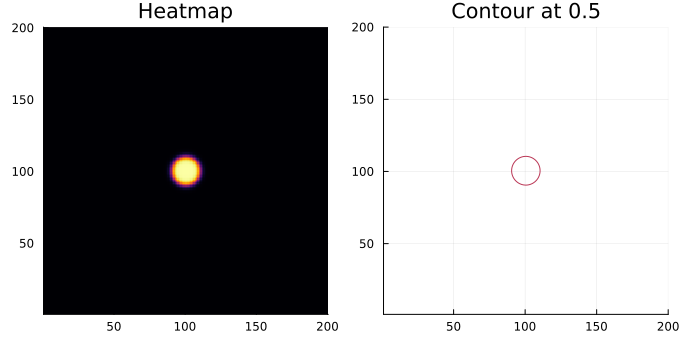

In [40]:
#for tiemstep in 1:1
    #every iteration
vector_of_results = [zeros(Nx, Ny) for _ in 1:size(fields,1)]
phis = [zeros(Nx, Ny) for _ in 1:size(types,1)]

f_term_result = similar(fields[1].h_field)
gs_result = similar(fields[1].h_field)
gint_result = similar(fields[1].h_field)
single_step!(vector_of_results, simulation_hyperparameters, fields, types, phis, f_term_result, gs_result, gint_result)
#end

plot_phase_field("test_run.png", fields, true)

# Evolution of one type according to simple rule
new = old + detla * derivative

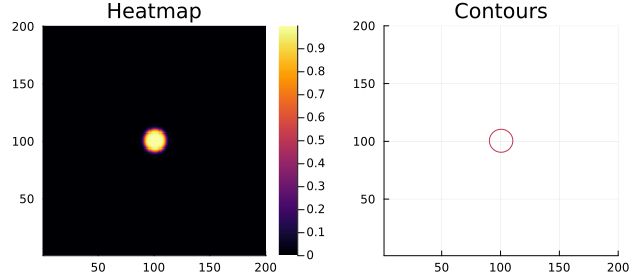

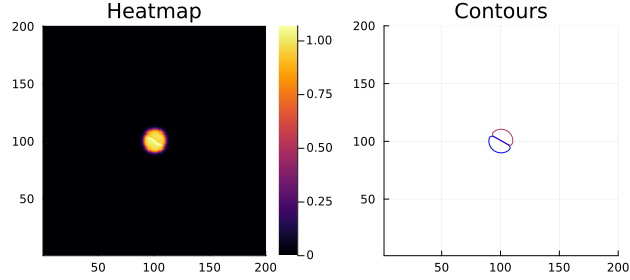

In [70]:
tau_u = 1.
D = 0.001

eta_s = 0.
eta = 0.
gamma = 0.
alpha = 1.
beta = 1.
beta_s = 0.

V_max = 1.


L = 1.

smoothness = 10.
volLim = 0.7

type1_hyp = initialize_type_hyperparameters(tau_u, D, eta_s, eta, gamma, alpha, beta, beta_s, V_max, L)
types = ["type1"]
field1 = PhaseField(simulation_hyperparameters, "type1", type1_hyp)
generate_cell!(field1, 5, 5, 0.5, smoothness)
fields = [field1]
for i in 1:size(fields,1)
    update_phase_field!(simulation_hyperparameters, fields[i])
end

# loop
dt = 0.01
number_of_iterations = 100
plot_phase_field("test_run.png", fields, true)
for t in 1:number_of_iterations
    vector_of_results = [zeros(Nx, Ny) for _ in 1:size(fields,1)]
    phis = [zeros(Nx, Ny) for _ in 1:size(types,1)]
    f_term_result = zeros(size(fields[1].h_field))
    gs_result = zeros(size(fields[1].h_field))
    gint_result = zeros(size(fields[1].h_field))
    vector_of_results = [zeros(Nx, Ny) for _ in 1:size(fields, 1)]
    single_step!(vector_of_results, simulation_hyperparameters, fields, types, phis, f_term_result, gs_result, gint_result)
    for i in 1:size(fields, 1)
        fields[i].field .+= vector_of_results[i] .* dt
        new_cell = cell_divide!(simulation_hyperparameters, fields[i], volLim, smoothness)
        if new_cell != false
            new_cell = PhaseField(simulation_hyperparameters, fields[i].type, fields[i].type_hyp, new_cell)
            push!(fields, new_cell)
        end
        update_phase_field!(simulation_hyperparameters, fields[i])
    end
end
plot_phase_field("test_run.png", fields, true)
